# BLEU, Perplexity, and ROUGE Evaluation on Generated Texts

In [1]:
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
import evaluate as hf_evaluate
from collections import defaultdict


project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Working directory: {Path.cwd()}")

Project root: c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen
Working directory: c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\results\evaluation


In [2]:
bleu_metric = hf_evaluate.load('bleu')
rouge_metric = hf_evaluate.load('rouge')
perplexity_metric = hf_evaluate.load('perplexity')

## Load Generated Texts from JSON

In [4]:
%pwd

'c:\\Users\\hayk_\\OneDrive\\Desktop\\05_LMU_Masters\\04_applied_dl\\adl-bnn-textgen\\results\\evaluation'

In [69]:
samplers_path = r"C:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\checkpoints\generation_results\last_eval_samplers.json"

baseline_path = r"C:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\checkpoints\generation_results\last_eval_baseline.json"


json_path = Path(baseline_path)

if not json_path.exists():
    raise FileNotFoundError(f"File not found: {json_path.absolute()}")

with open(json_path, 'r') as f:
    generation_results = json.load(f)

print(f"Num samples: {len(generation_results)}")


Num samples: 40


## Loading reference data

In [70]:
data_dir = project_root / "notebooks" / "nanogpt" / "data" / "shakespeare_char"
val_data_path = data_dir / "val.bin"
if not val_data_path.exists():
    raise FileNotFoundError(f"Validation data not found at: {val_data_path}")

# tokenizer
meta_path = project_root / "checkpoints" / "baseline_nanogpt" / "meta.pkl"

if not meta_path.exists():
    raise FileNotFoundError(f"Meta file not found at: {meta_path}")

import pickle
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

# Load validation data
val_data = np.memmap(str(val_data_path), dtype=np.uint16, mode='r')
print(f"Loaded validation data: {len(val_data)} tokens")
print(f"Vocabulary size: {len(itos)}")

# Load train data  
train_data_path = data_dir / "train.bin"
train_data = np.memmap(str(train_data_path), dtype=np.uint16, mode='r')
print(f"Loaded train data: {len(train_data)} tokens")

Loaded validation data: 111540 tokens
Vocabulary size: 65
Loaded train data: 1003854 tokens


## Helper Functions for Metrics Calculation

In [71]:
def get_tokenizer(stoi):
    def custom_tokenizer(text):
        return [ch for ch in text if ch in stoi]
    return custom_tokenizer

def find_prompt_in_data(prompt: str, data, encode_fn, max_search_positions=1000000):
    prompt_tokens = encode_fn(prompt)
    
    if not prompt_tokens:
        return None
    
    prompt_len = len(prompt_tokens)
    
    search_limit = min(len(data) - prompt_len - 100, max_search_positions)
    
    data_array = np.array(data[:search_limit + prompt_len])
    prompt_array = np.array(prompt_tokens)
    
    for i in range(0, search_limit):
        if i + prompt_len >= len(data_array):
            break
            
        if np.array_equal(data_array[i:i + prompt_len], prompt_array):
            return i + prompt_len
    
    return None

def extract_references_for_prompts(prompts, train_data, val_data, encode_fn, decode_fn, generation_length=100):

    references = []
    found_indices = []
    not_found_prompts = []
    
    for idx, prompt in enumerate(prompts):
        # First search in train 
        continuation_start = find_prompt_in_data(prompt, train_data, encode_fn, max_search_positions=500000)
        data_source = train_data
        
        # If not found in train, try validation
        if continuation_start is None:
            continuation_start = find_prompt_in_data(prompt, val_data, encode_fn, max_search_positions=500000)
            data_source = val_data
        
        if continuation_start is None:
            not_found_prompts.append(prompt)
            continue
        
        if continuation_start + generation_length <= len(data_source):
            ref_tokens = data_source[continuation_start:continuation_start + generation_length]
            reference_text = decode_fn(ref_tokens.tolist()).strip()
            references.append(reference_text)
            found_indices.append(idx)
        else:
            not_found_prompts.append(prompt)
    
    if not_found_prompts:
        print(f"{len(not_found_prompts)} prompts not found")
    
    if not references:
        raise ValueError("No references founded")
    
    return references, found_indices

def calculate_bleu_score(references, predictions, tokenizer):
    if not references or not predictions:
        raise ValueError(f"Cannot calc BLEU: references={len(references)}, predictions={len(predictions)}")
    
    if len(references) != len(predictions):
        raise ValueError(f"Mismatch: {len(references)} references vs {len(predictions)} predictions")
    
    formatted_refs = [[r] for r in references]
    
    result = bleu_metric.compute(
        predictions=predictions,
        references=formatted_refs,
        tokenizer=tokenizer
    )
    return float(result.get('bleu', 0.0))

def calculate_rouge_scores(references, predictions, tokenizer):
    if not references or not predictions:
        raise ValueError(f"Cannot calc ROUGE: references={len(references)}, predictions={len(predictions)}")
    
    if len(references) != len(predictions):
        raise ValueError(f"Mismatch: {len(references)} references vs {len(predictions)} predictions")
    
    result = rouge_metric.compute(
        predictions=predictions,
        references=references,
        tokenizer=tokenizer
    )
    return {
        'rouge1': float(result.get('rouge1', 0.0)),
        'rouge2': float(result.get('rouge2', 0.0)),
        'rougeL': float(result.get('rougeL', 0.0)),
    }

def calculate_perplexity(texts):
    if not texts:
        raise ValueError("no texts provided")
    
    result = perplexity_metric.compute(
        predictions=texts,
        model_id='gpt2'
    )
    return float(result.get('mean_perplexity', None))

## Organizing data

In [23]:
grouped_data = defaultdict(list)

for sample_id, data in generation_results.items():
    model_path = data.get('model_path', 'unknown')
    temperature = data.get('temperature', 'unknown')
    top_k = data.get('top_k', 'unknown')
    num_samples = data.get('num_samples', 'unknown')
    prompt_source = data.get('prompt_source', 'unknown')
    
    run_name = Path(model_path).parent.name if model_path != 'unknown' else 'unknown'
    model_name = Path(model_path).name.removesuffix("_model.pt") if model_path != 'unknown' else 'unknown'
    
    if "baseline_model_2k.pt" in model_name:
        model_name = "baseline"
    elif model_name.endswith(".pt"):
        model_name = model_name.removesuffix(".pt")
    
    group_key = f"{model_name}_temp{temperature}_topk{top_k}_samples{num_samples}_{run_name}"
    
    grouped_data[group_key].append({
        'id': sample_id,
        'prompt': data.get('prompt', ''),
        'prompt_source': prompt_source,
        'generated_text': data.get('generated_text', ''),
        'model_path': model_path,
        "model_name": model_name,
        'temperature': temperature,
        'top_k': top_k,
        'num_samples': num_samples
    })

print(f"Found {len(grouped_data)} unique configurations:")
for key, items in list(grouped_data.items())[:5]:
    train_count = sum(1 for item in items if item['prompt_source'] == 'train')
    val_count = sum(1 for item in items if item['prompt_source'] == 'val')

    print(f"  {key}: {len(items)} samples (train: {train_count}, val: {val_count})")

Found 8 unique configurations:
  baseline_temp0.3_topk10_samples10_baseline: 5 samples (train: 3, val: 2)
  baseline_temp0.3_topk10_samples30_baseline: 5 samples (train: 3, val: 2)
  baseline_temp0.3_topk50_samples10_baseline: 5 samples (train: 3, val: 2)
  baseline_temp0.3_topk50_samples30_baseline: 5 samples (train: 3, val: 2)
  baseline_temp0.8_topk10_samples10_baseline: 5 samples (train: 3, val: 2)


## Calculate Metrics for Each Configuration

In [24]:
from tqdm import tqdm

In [ ]:
results_summary = {}

tokenizer = get_tokenizer(stoi)

all_unique_prompts = set()
for samples in grouped_data.values():
    for s in samples:
        if s['generated_text']:
            all_unique_prompts.add(s['prompt'])

all_unique_prompts = list(all_unique_prompts)
print(f"{len(all_unique_prompts)} unique prompts")

try:
    all_references, all_found_indices = extract_references_for_prompts(
        all_unique_prompts,
        train_data,
        val_data,
        encode,
        decode,
        generation_length=1000
    )
    
    prompt_to_reference = {}
    for idx in all_found_indices:
        prompt_to_reference[all_unique_prompts[idx]] = all_references[all_found_indices.index(idx)]
    
except Exception as e:
    print(f" Error {e}")
    prompt_to_reference = {}


for config_key, samples in tqdm(grouped_data.items()):
    print(f"Processing: {config_key} ({len(samples)} samples)")
    
    train_samples = [s for s in samples if s.get('prompt_source') == 'train' and s['generated_text']]
    val_samples = [s for s in samples if s.get('prompt_source') == 'val' and s['generated_text']]
    all_samples = [s for s in samples if s['generated_text']]
    
    if not all_samples:
        print(f"No valid predictions found, skipping\n")
        continue
    
    print(f"Train samples: {len(train_samples)}, Val: {len(val_samples)}")
    
    def calculate_metrics_for_samples(sample_list, subset_name):
        if not sample_list:
            return None
        
        filtered_samples = [s for s in sample_list if s['prompt'] in prompt_to_reference]
        
        if not filtered_samples:
            print(f"No references for {subset_name}")
            return None
        
        predictions = [s['generated_text'] for s in filtered_samples]
        references = [prompt_to_reference[s['prompt']] for s in filtered_samples]
        
        if len(predictions) != len(references):
            print(f"Error: Mismatch - {len(references)} references; {len(predictions)} predictions")
            return None
        
        try:
            bleu_score = calculate_bleu_score(references, predictions, tokenizer)
            rouge_scores = calculate_rouge_scores(references, predictions, tokenizer)
            perplexity = calculate_perplexity(predictions)
            
            return {
                'num_samples': len(filtered_samples),
                'num_prompts_not_found': len(sample_list) - len(filtered_samples),
                'bleu': bleu_score,
                'rouge1': rouge_scores['rouge1'],
                'rouge2': rouge_scores['rouge2'],
                'rougeL': rouge_scores['rougeL'],
                'perplexity': perplexity,
                'avg_text_length': np.mean([len(p) for p in predictions])
            }
        except Exception as e:
            print(f"  Error calculating metrics for {subset_name}: {e}")
            return None
    
    overall_metrics = calculate_metrics_for_samples(all_samples, "overall")
    train_metrics = calculate_metrics_for_samples(train_samples, "train") if train_samples else None    
    val_metrics = calculate_metrics_for_samples(val_samples, "val") if val_samples else None
    
    results_summary[config_key] = {
        'model_path': samples[0]['model_path'],
        "model_name": samples[0]['model_name'],
        'temperature': samples[0]['temperature'],
        'num_samples': samples[0]['num_samples'],
        'overall': overall_metrics,
        'train': train_metrics,
        'val': val_metrics
    }


5 unique prompts
1 prompts not found


  0%|          | 0/8 [00:00<?, ?it/s]

Processing: baseline_temp0.3_topk10_samples10_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:23<02:41, 23.10s/it]

Processing: baseline_temp0.3_topk10_samples30_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [01:17<04:08, 41.41s/it]

Processing: baseline_temp0.3_topk50_samples10_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [02:50<05:25, 65.16s/it]

Processing: baseline_temp0.3_topk50_samples30_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 4/8 [03:49<04:11, 62.79s/it]

Processing: baseline_temp0.8_topk10_samples10_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [05:28<03:46, 75.66s/it]

Processing: baseline_temp0.8_topk10_samples30_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [05:49<01:53, 56.99s/it]

Processing: baseline_temp0.8_topk50_samples10_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [06:08<00:44, 44.61s/it]

Processing: baseline_temp0.8_topk50_samples30_baseline (5 samples)
Train samples: 3, Val: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 8/8 [06:24<00:00, 48.07s/it]


## Display Results as DataFrame

In [27]:
# save results_summary to json
results_summary_path = project_root / "results" / "evaluation" / "baseline_classic_eval.json"
with open(results_summary_path, 'w') as f:
    json.dump(results_summary, f, indent=4)

In [ ]:

def create_df_from_results(results_dict, metric_type='overall'):
    rows = []
    for config_key, config_data in results_dict.items():
        metrics = config_data.get(metric_type)
        if metrics is not None:
            row = {
                'config': config_key,
                'model_path': config_data['model_path'],
                'temperature': config_data['temperature'],
                'top_k': config_data['top_k'],
                **metrics
            }
            rows.append(row)
    return pd.DataFrame(rows).set_index('config')

df_overall = create_df_from_results(results_summary, 'overall')
df_train = create_df_from_results(results_summary, 'train')
df_val = create_df_from_results(results_summary, 'val')


if not df_overall.empty:
    df_overall = df_overall.sort_values('bleu', ascending=False)
if not df_train.empty:
    df_train = df_train.sort_values('bleu', ascending=False)
if not df_val.empty:
    df_val = df_val.sort_values('bleu', ascending=False)


if not df_overall.empty:
    print(df_overall[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No overall results available")
print()

print("Train:")
if not df_train.empty:
    print(df_train[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No train results available")
print()

print("Val:")
if not df_val.empty:
    print(df_val[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No validation results available")

df_overall


                                            num_samples      bleu    rouge1    rouge2    rougeL  perplexity  temperature  top_k
config                                                                                                                         
baseline_temp0.8_topk50_samples10_baseline            4  0.285397  0.757813  0.581048  0.382656  198.900846          0.8     50
baseline_temp0.8_topk10_samples30_baseline            4  0.275646  0.748615  0.553484  0.379069  127.048693          0.8     10
baseline_temp0.8_topk10_samples10_baseline            4  0.274682  0.756265  0.561419  0.379659  172.017941          0.8     10
baseline_temp0.8_topk50_samples30_baseline            4  0.263786  0.743997  0.548213  0.369576  279.195232          0.8     50
baseline_temp0.3_topk50_samples30_baseline            4  0.245075  0.746812  0.496840  0.384469   86.297112          0.3     50
baseline_temp0.3_topk10_samples30_baseline            4  0.244308  0.730255  0.485750  0.385780   46.525

,model_path,temperature,top_k,num_samples,num_prompts_not_found,bleu,rouge1,rouge2,rougeL,perplexity,avg_text_length
config,,,,,,,,,,,
baseline_temp0.8_topk50_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,50,4,1,0.285397,0.757813,0.581048,0.382656,198.900846,634.75
baseline_temp0.8_topk10_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,10,4,1,0.275646,0.748615,0.553484,0.379069,127.048693,634.75
baseline_temp0.8_topk10_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,10,4,1,0.274682,0.756265,0.561419,0.379659,172.017941,634.75
baseline_temp0.8_topk50_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,50,4,1,0.263786,0.743997,0.548213,0.369576,279.195232,634.75
baseline_temp0.3_topk50_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,50,4,1,0.245075,0.746812,0.496840,0.384469,86.297112,634.75
baseline_temp0.3_topk10_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,10,4,1,0.244308,0.730255,0.485750,0.385780,46.525049,634.75
baseline_temp0.3_topk50_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,50,4,1,0.238666,0.726856,0.482101,0.380560,36.024972,634.75
baseline_temp0.3_topk10_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,10,4,1,0.237451,0.726575,0.473880,0.383631,59.152245,634.75


In [30]:
results_samplers_path = project_root / "results" / "evaluation" / "samplers_classic_eval.json"

# read and display results
with open(results_samplers_path, 'r') as f:
    samplers_results = json.load(f)
    
    
df_overall_samplers = create_df_from_results(samplers_results, 'overall')
df_train_samplers = create_df_from_results(samplers_results, 'train')
df_val_samplers = create_df_from_results(samplers_results, 'val')


if not df_overall_samplers.empty:
    df_overall_samplers = df_overall_samplers.sort_values('bleu', ascending=False)
if not df_train_samplers.empty:
    df_train_samplers = df_train_samplers.sort_values('bleu', ascending=False)
if not df_val_samplers.empty:
    df_val_samplers = df_val_samplers.sort_values('bleu', ascending=False)




In [54]:
samplers_results

{'baoa_temp0.3_topk10_samples10_run_20251224-145920': {'model_path': '/content/drive/MyDrive/samplers/baoa_sampler/run_20251224-145920/baoa_model.pt',
  'model_name': 'baoa',
  'temperature': 0.3,
  'top_k': 10,
  'overall': {'num_samples': 4,
   'num_prompts_not_found': 1,
   'bleu': 0.23338351780012792,
   'rouge1': 0.718866644061357,
   'rouge2': 0.4703100013466997,
   'rougeL': 0.37353228518727055,
   'perplexity': 39.520681858062744,
   'avg_text_length': 634.75},
  'train': {'num_samples': 3,
   'num_prompts_not_found': 0,
   'bleu': 0.23406613700489512,
   'rouge1': 0.7193717526785802,
   'rouge2': 0.46951912600267964,
   'rougeL': 0.3676526933500415,
   'perplexity': 35.87831942240397,
   'avg_text_length': 635.6666666666666},
  'val': {'num_samples': 1,
   'num_prompts_not_found': 1,
   'bleu': 0.2313266356672956,
   'rouge1': 0.7173513182096873,
   'rouge2': 0.47268262737876,
   'rougeL': 0.3911710606989577,
   'perplexity': 50.447792053222656,
   'avg_text_length': 632.0}},


In [ ]:
df_overall_samplersa

,model_path,temperature,top_k,num_samples,num_prompts_not_found,bleu,rouge1,rouge2,rougeL,perplexity,avg_text_length
config,,,,,,,,,,,
baoa_temp0.8_topk10_samples30_run_20251224-145920,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,10,4,1,0.279271,0.754756,0.559603,0.379637,178.991688,634.75
baoa_temp0.8_topk50_samples10_run_20251224-145920,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,50,4,1,0.274921,0.746757,0.558332,0.380598,141.470057,634.75
baoa_temp0.8_topk10_samples10_run_20251224-145920,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,10,4,1,0.272899,0.752607,0.544857,0.379055,146.189201,634.75
sghmc_temp0.8_topk10_samples30_run_20251226-113201,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,10,4,1,0.271406,0.753536,0.556883,0.375705,206.586113,634.75
sghmc_temp0.8_topk50_samples10_run_20251226-113201,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,50,4,1,0.266942,0.755072,0.562225,0.379069,215.752899,634.75
sghmc_temp0.8_topk10_samples10_run_20251226-113201,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,10,4,1,0.262910,0.750153,0.544571,0.378364,194.718197,634.75
baoa_temp0.8_topk50_samples30_run_20251224-145920,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,50,4,1,0.262071,0.751690,0.545178,0.372948,174.086641,634.75
baoa_temp0.3_topk50_samples10_run_20251224-145920,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.3,50,4,1,0.260473,0.746146,0.511450,0.396136,71.252941,634.75
sghmc_temp0.3_topk50_samples10_run_20251226-113201,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.3,50,4,1,0.254528,0.737581,0.507549,0.383881,57.449103,634.75


In [32]:
df_overall

,model_path,temperature,top_k,num_samples,num_prompts_not_found,bleu,rouge1,rouge2,rougeL,perplexity,avg_text_length
config,,,,,,,,,,,
baseline_temp0.8_topk50_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,50,4,1,0.285397,0.757813,0.581048,0.382656,198.900846,634.75
baseline_temp0.8_topk10_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,10,4,1,0.275646,0.748615,0.553484,0.379069,127.048693,634.75
baseline_temp0.8_topk10_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,10,4,1,0.274682,0.756265,0.561419,0.379659,172.017941,634.75
baseline_temp0.8_topk50_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.8,50,4,1,0.263786,0.743997,0.548213,0.369576,279.195232,634.75
baseline_temp0.3_topk50_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,50,4,1,0.245075,0.746812,0.496840,0.384469,86.297112,634.75
baseline_temp0.3_topk10_samples30_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,10,4,1,0.244308,0.730255,0.485750,0.385780,46.525049,634.75
baseline_temp0.3_topk50_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,50,4,1,0.238666,0.726856,0.482101,0.380560,36.024972,634.75
baseline_temp0.3_topk10_samples10_baseline,/content/drive/MyDrive/baseline/baseline_model...,0.3,10,4,1,0.237451,0.726575,0.473880,0.383631,59.152245,634.75


In [34]:
# put rows under each other for comparison
df_overall_concat = pd.concat([df_overall_samplers.add_suffix('_sampler'), df_overall.add_suffix('_baseline')], axis=1)
df_train_concat = pd.concat([df_train_samplers.add_suffix('_sampler'), df_train.add_suffix('_baseline')], axis=1)
df_val_concat = pd.concat([df_val_samplers.add_suffix('_sampler'), df_val.add_suffix('_baseline')], axis=1)

In [ ]:
# read json
results_summay_samplers

with open(results_samplers_path, 'r') as f:
    samplers_results = json.load(f) 

In [36]:
samplers_results

{'baoa_temp0.3_topk10_samples10_run_20251224-145920': {'model_path': '/content/drive/MyDrive/samplers/baoa_sampler/run_20251224-145920/baoa_model.pt',
  'model_name': 'baoa',
  'temperature': 0.3,
  'top_k': 10,
  'overall': {'num_samples': 4,
   'num_prompts_not_found': 1,
   'bleu': 0.23338351780012792,
   'rouge1': 0.718866644061357,
   'rouge2': 0.4703100013466997,
   'rougeL': 0.37353228518727055,
   'perplexity': 39.520681858062744,
   'avg_text_length': 634.75},
  'train': {'num_samples': 3,
   'num_prompts_not_found': 0,
   'bleu': 0.23406613700489512,
   'rouge1': 0.7193717526785802,
   'rouge2': 0.46951912600267964,
   'rougeL': 0.3676526933500415,
   'perplexity': 35.87831942240397,
   'avg_text_length': 635.6666666666666},
  'val': {'num_samples': 1,
   'num_prompts_not_found': 1,
   'bleu': 0.2313266356672956,
   'rouge1': 0.7173513182096873,
   'rouge2': 0.47268262737876,
   'rougeL': 0.3911710606989577,
   'perplexity': 50.447792053222656,
   'avg_text_length': 632.0}},


In [35]:
results_summary 

{'baseline_temp0.3_topk10_samples10_baseline': {'model_path': '/content/drive/MyDrive/baseline/baseline_model_2k.pt',
  'model_name': 'baseline',
  'temperature': 0.3,
  'top_k': 10,
  'overall': {'num_samples': 4,
   'num_prompts_not_found': 1,
   'bleu': 0.2374507051675465,
   'rouge1': 0.7265746742786999,
   'rouge2': 0.473879515405446,
   'rougeL': 0.38363122085084433,
   'perplexity': 59.152244567871094,
   'avg_text_length': np.float64(634.75)},
  'train': {'num_samples': 3,
   'num_prompts_not_found': 0,
   'bleu': 0.2367438656765538,
   'rouge1': 0.7427290363773222,
   'rouge2': 0.4763247232211758,
   'rougeL': 0.385614159989967,
   'perplexity': 70.41405868530273,
   'avg_text_length': np.float64(635.6666666666666)},
  'val': {'num_samples': 1,
   'num_prompts_not_found': 1,
   'bleu': 0.23904383771542004,
   'rouge1': 0.6781115879828326,
   'rouge2': 0.4665438919582566,
   'rougeL': 0.37768240343347637,
   'perplexity': 25.366802215576172,
   'avg_text_length': np.float64(632

In [38]:
!pip install jsonmerge


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: C:\Users\hayk_\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [41]:
results_summary.keys()

dict_keys(['baseline_temp0.3_topk10_samples10_baseline', 'baseline_temp0.3_topk10_samples30_baseline', 'baseline_temp0.3_topk50_samples10_baseline', 'baseline_temp0.3_topk50_samples30_baseline', 'baseline_temp0.8_topk10_samples10_baseline', 'baseline_temp0.8_topk10_samples30_baseline', 'baseline_temp0.8_topk50_samples10_baseline', 'baseline_temp0.8_topk50_samples30_baseline'])

In [42]:
samplers_results.keys()

dict_keys(['baoa_temp0.3_topk10_samples10_run_20251224-145920', 'baoa_temp0.3_topk50_samples10_run_20251224-145920', 'baoa_temp0.3_topk10_samples30_run_20251224-145920', 'baoa_temp0.8_topk10_samples10_run_20251224-145920', 'baoa_temp0.3_topk50_samples30_run_20251224-145920', 'baoa_temp0.8_topk50_samples10_run_20251224-145920', 'baoa_temp0.8_topk10_samples30_run_20251224-145920', 'baoa_temp0.8_topk50_samples30_run_20251224-145920', 'sghmc_temp0.3_topk10_samples10_run_20251226-113201', 'sghmc_temp0.3_topk50_samples10_run_20251226-113201', 'sghmc_temp0.3_topk10_samples30_run_20251226-113201', 'sghmc_temp0.8_topk10_samples10_run_20251226-113201', 'sghmc_temp0.3_topk50_samples30_run_20251226-113201', 'sghmc_temp0.8_topk50_samples10_run_20251226-113201', 'sghmc_temp0.8_topk10_samples30_run_20251226-113201', 'sghmc_temp0.8_topk50_samples30_run_20251226-113201'])

In [ ]:
#dict_keys(['baoa_temp0.3_topk10_samples10_run_20251224-145920', 'baoa_temp0.3_topk50_samples10_run_20251224-145920', 'baoa_temp0.3_topk10_samples30_run_20251224-145920', 'baoa_temp0.8_topk10_samples10_run_20251224-145920', 'baoa_temp0.3_topk50_samples30_run_20251224-145920', 'baoa_temp0.8_topk50_samples10_run_20251224-145920', 'baoa_temp0.8_topk10_samples30_run_20251224-145920', 'baoa_temp0.8_topk50_samples30_run_20251224-145920', 'sghmc_temp0.3_topk10_samples10_run_20251226-113201', 'sghmc_temp0.3_topk50_samples10_run_20251226-113201', 'sghmc_temp0.3_topk10_samples30_run_20251226-113201', 'sghmc_temp0.8_topk10_samples10_run_20251226-113201', 'sghmc_temp0.3_topk50_samples30_run_20251226-113201', 'sghmc_temp0.8_topk50_samples10_run_20251226-113201', 'sghmc_temp0.8_topk10_samples30_run_20251226-113201', 'sghmc_temp0.8_topk50_samples30_run_20251226-113201'])
# dict_keys(['baseline_temp0.3_topk10_samples10_baseline', 'baseline_temp0.3_topk10_samples30_baseline', 'baseline_temp0.3_topk50_samples10_baseline', 'baseline_temp0.3_topk50_samples30_baseline', 'baseline_temp0.8_topk10_samples10_baseline', 'baseline_temp0.8_topk10_samples30_baseline', 'baseline_temp0.8_topk50_samples10_baseline', 'baseline_temp0.8_topk50_samples30_baseline'])

json1 = results_summary
json2 = samplers_results

# append jsons by adding keys, don't use jsonmerge

 

ModuleNotFoundError: No module named 'jsonmerge'

In [59]:

# results\evaluation\llm_results\evaluation_metrics_results.json
path_all = Path("llm_results/evaluation_metrics_results.json")

# read json
with open(path_all) as file:
    results_all = json.load(file)

results_summary = results_all["metrics"]

In [77]:
for k, v in results_summary.items():
    ind = k.find("samples") + len("samples")
    # print(k[ind:ind+2])
    results_summary[k]["num_samples"] = int(k[ind:ind+2]) 

## Code for presentation preparation (Initial version done almost fully by Claude Sonnet)

In [78]:
# Group results by model name
model_grouped = {}

for config_key, config_data in results_summary.items():
    model_path = config_data['model_path']
    model_name = Path(model_path).name.removesuffix("_model.pt") if model_path != 'unknown' else 'unknown'
    
    if "baseline_model_2k.pt" in model_name:
        model_name = "baseline"
    elif model_name.endswith(".pt"):
        model_name = model_name.removesuffix(".pt")

    # model_name = config_data['model_name']
    
    if model_name not in model_grouped:
        model_grouped[model_name] = {
            'overall': [],
            'train': [],
            'val': []
        }
    
    # Collect overall metrics
    if config_data.get('overall'):
        model_grouped[model_name]['overall'].append(config_data['overall'])
    
    # Collect train metrics
    if config_data.get('train'):
        model_grouped[model_name]['train'].append(config_data['train'])
    
    # Collect val metrics
    if config_data.get('val'):
        model_grouped[model_name]['val'].append(config_data['val'])

print(f"Found {len(model_grouped)} unique models")
print(f"Models: {list(model_grouped.keys())}")

# Calculate aggregate statistics for each model
def calculate_aggregate_stats(metrics_list):
    """Calculate mean and median for a list of metric dictionaries"""
    if not metrics_list:
        return None
    
    # Extract values for each metric
    bleu_values = [m['bleu'] for m in metrics_list]
    rouge1_values = [m['rouge1'] for m in metrics_list]
    rouge2_values = [m['rouge2'] for m in metrics_list]
    rougeL_values = [m['rougeL'] for m in metrics_list]
    perplexity_values = [m['perplexity'] for m in metrics_list]
    
    return {
        'num_configs': len(metrics_list),
        'bleu_mean': np.mean(bleu_values),
        'bleu_median': np.median(bleu_values),
        'rouge1_mean': np.mean(rouge1_values),
        'rouge1_median': np.median(rouge1_values),
        'rouge2_mean': np.mean(rouge2_values),
        'rouge2_median': np.median(rouge2_values),
        'rougeL_mean': np.mean(rougeL_values),
        'rougeL_median': np.median(rougeL_values),
        'perplexity_mean': np.mean(perplexity_values),
        'perplexity_median': np.median(perplexity_values),
    }

# Compute aggregate statistics
model_stats = {}
for model_name, metrics_dict in model_grouped.items():
    model_stats[model_name] = {
        'overall': calculate_aggregate_stats(metrics_dict['overall']),
        'train': calculate_aggregate_stats(metrics_dict['train']),
        'val': calculate_aggregate_stats(metrics_dict['val'])
    }

print("\n" + "="*120)
print("MODEL-LEVEL AGGREGATE STATISTICS")
print("="*120)

for model_name, stats in model_stats.items():
    print(f"\n### MODEL: {model_name} ###")
    
    # Overall stats
    if stats['overall']:
        overall = stats['overall']
        print(f"\nOVERALL ({overall['num_configs']} configurations):")
        print(f"  BLEU:       Mean={overall['bleu_mean']:.4f}, Median={overall['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={overall['rouge1_mean']:.4f}, Median={overall['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={overall['rouge2_mean']:.4f}, Median={overall['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={overall['rougeL_mean']:.4f}, Median={overall['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={overall['perplexity_mean']:.2f}, Median={overall['perplexity_median']:.2f}")
    
    # Train stats
    if stats['train']:
        train = stats['train']
        print(f"\nTRAIN ({train['num_configs']} configurations):")
        print(f"  BLEU:       Mean={train['bleu_mean']:.4f}, Median={train['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={train['rouge1_mean']:.4f}, Median={train['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={train['rouge2_mean']:.4f}, Median={train['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={train['rougeL_mean']:.4f}, Median={train['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={train['perplexity_mean']:.2f}, Median={train['perplexity_median']:.2f}")
    
    # Val stats
    if stats['val']:
        val = stats['val']
        print(f"\nVAL ({val['num_configs']} configurations):")
        print(f"  BLEU:       Mean={val['bleu_mean']:.4f}, Median={val['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={val['rouge1_mean']:.4f}, Median={val['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={val['rouge2_mean']:.4f}, Median={val['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={val['rougeL_mean']:.4f}, Median={val['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={val['perplexity_mean']:.2f}, Median={val['perplexity_median']:.2f}")

print("\n" + "="*120)

Found 3 unique models
Models: ['baseline', 'baoa', 'sghmc']

MODEL-LEVEL AGGREGATE STATISTICS

### MODEL: baseline ###

OVERALL (8 configurations):
  BLEU:       Mean=0.2581, Median=0.2544
  ROUGE-1:    Mean=0.7421, Median=0.7454
  ROUGE-2:    Mean=0.5228, Median=0.5225
  ROUGE-L:    Mean=0.3807, Median=0.3816
  Perplexity: Mean=125.65, Median=106.67

TRAIN (8 configurations):
  BLEU:       Mean=0.2556, Median=0.2548
  ROUGE-1:    Mean=0.7454, Median=0.7497
  ROUGE-2:    Mean=0.5221, Median=0.5265
  ROUGE-L:    Mean=0.3762, Median=0.3752
  Perplexity: Mean=129.42, Median=109.88

VAL (8 configurations):
  BLEU:       Mean=0.2651, Median=0.2689
  ROUGE-1:    Mean=0.7325, Median=0.7382
  ROUGE-2:    Mean=0.5250, Median=0.5298
  ROUGE-L:    Mean=0.3932, Median=0.3967
  Perplexity: Mean=114.32, Median=94.48

### MODEL: baoa ###

OVERALL (8 configurations):
  BLEU:       Mean=0.2561, Median=0.2613
  ROUGE-1:    Mean=0.7392, Median=0.7465
  ROUGE-2:    Mean=0.5146, Median=0.5282
  ROUGE-L:   

In [79]:
# Create summary DataFrame for model-level statistics
model_summary_rows = []

for model_name, stats in model_stats.items():
    if stats['overall']:
        overall = stats['overall']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Overall',
            'Configs': overall['num_configs'],
            'BLEU (Mean)': overall['bleu_mean'],
            'BLEU (Median)': overall['bleu_median'],
            'ROUGE-1 (Mean)': overall['rouge1_mean'],
            'ROUGE-1 (Median)': overall['rouge1_median'],
            'ROUGE-L (Mean)': overall['rougeL_mean'],
            'ROUGE-L (Median)': overall['rougeL_median'],
            'Perplexity (Mean)': overall['perplexity_mean'],
            'Perplexity (Median)': overall['perplexity_median'],
        })
    
    if stats['train']:
        train = stats['train']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Train',
            'Configs': train['num_configs'],
            'BLEU (Mean)': train['bleu_mean'],
            'BLEU (Median)': train['bleu_median'],
            'ROUGE-1 (Mean)': train['rouge1_mean'],
            'ROUGE-1 (Median)': train['rouge1_median'],
            'ROUGE-L (Mean)': train['rougeL_mean'],
            'ROUGE-L (Median)': train['rougeL_median'],
            'Perplexity (Mean)': train['perplexity_mean'],
            'Perplexity (Median)': train['perplexity_median'],
        })
    
    if stats['val']:
        val = stats['val']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Val',
            'Configs': val['num_configs'],
            'BLEU (Mean)': val['bleu_mean'],
            'BLEU (Median)': val['bleu_median'],
            'ROUGE-1 (Mean)': val['rouge1_mean'],
            'ROUGE-1 (Median)': val['rouge1_median'],
            'ROUGE-L (Mean)': val['rougeL_mean'],
            'ROUGE-L (Median)': val['rougeL_median'],
            'Perplexity (Mean)': val['perplexity_mean'],
            'Perplexity (Median)': val['perplexity_median'],
        })

df_model_summary = pd.DataFrame(model_summary_rows)

print("\n" + "="*120)
print("MODEL SUMMARY TABLE")
print("="*120)
print(df_model_summary.to_string(index=False))
print("="*120)

# Display as interactive table
df_model_summary


MODEL SUMMARY TABLE
   Model Dataset  Configs  BLEU (Mean)  BLEU (Median)  ROUGE-1 (Mean)  ROUGE-1 (Median)  ROUGE-L (Mean)  ROUGE-L (Median)  Perplexity (Mean)  Perplexity (Median)
baseline Overall        8     0.258126       0.254431        0.742148          0.745404        0.380675          0.381608         125.645261           106.672903
baseline   Train        8     0.255600       0.254755        0.745356          0.749659        0.376235          0.375196         129.421154           109.881793
baseline     Val        8     0.265100       0.268926        0.732526          0.738197        0.393164          0.396689         114.317519            94.483089
    baoa Overall        8     0.256074       0.261272        0.739235          0.746452        0.379733          0.379346         105.735896           106.361499
    baoa   Train        8     0.251538       0.258042        0.737946          0.743889        0.373227          0.371539         105.894481           104.118558
    bao

,Model,Dataset,Configs,BLEU (Mean),BLEU (Median),ROUGE-1 (Mean),ROUGE-1 (Median),ROUGE-L (Mean),ROUGE-L (Median),Perplexity (Mean),Perplexity (Median)
0,baseline,Overall,8,0.258126,0.254431,0.742148,0.745404,0.380675,0.381608,125.645261,106.672903
1,baseline,Train,8,0.255600,0.254755,0.745356,0.749659,0.376235,0.375196,129.421154,109.881793
2,baseline,Val,8,0.265100,0.268926,0.732526,0.738197,0.393164,0.396689,114.317519,94.483089
3,baoa,Overall,8,0.256074,0.261272,0.739235,0.746452,0.379733,0.379346,105.735896,106.361499
4,baoa,Train,8,0.251538,0.258042,0.737946,0.743889,0.373227,0.371539,105.894481,104.118558
5,baoa,Val,8,0.269272,0.270668,0.743102,0.748620,0.398375,0.395463,105.260211,79.414341
6,sghmc,Overall,8,0.252249,0.252078,0.741825,0.738415,0.378393,0.378716,122.377468,101.603950
7,sghmc,Train,8,0.249450,0.252641,0.739508,0.738079,0.371451,0.371758,125.405167,105.161273
8,sghmc,Val,8,0.260059,0.262563,0.748774,0.747394,0.398222,0.397302,113.294397,113.565651


Saved plot to evaluation_results\model_comparison_overall.png


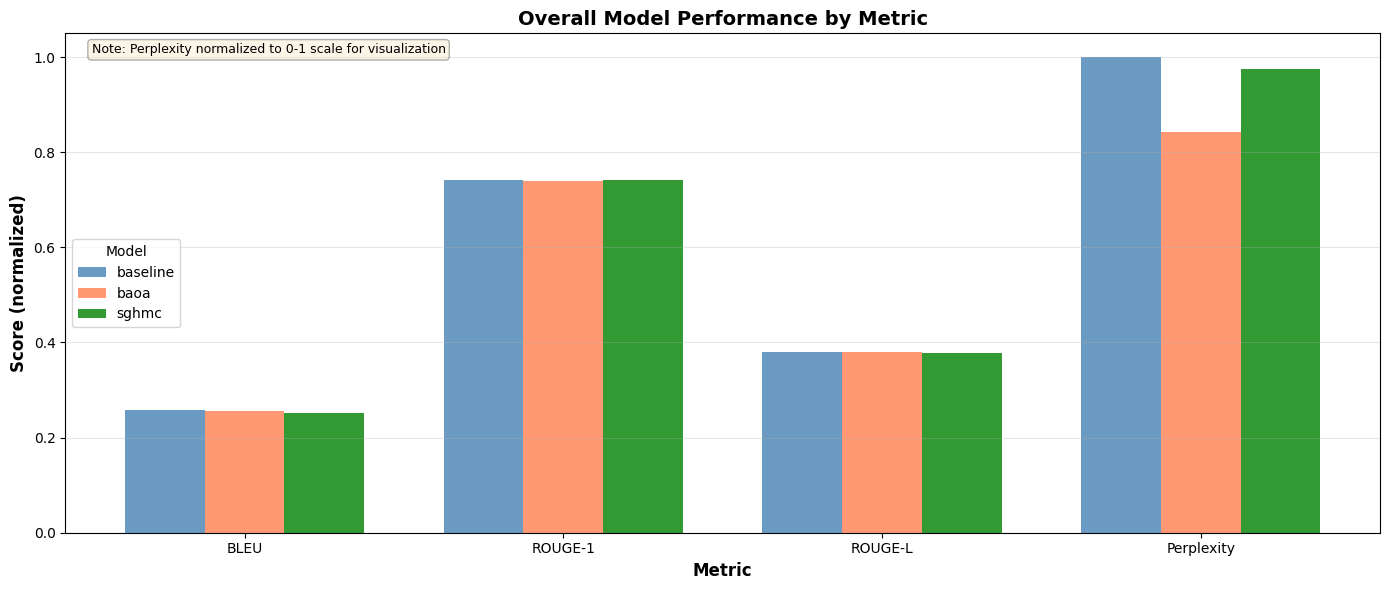

Model comparison barplot created successfully


In [80]:
import matplotlib.pyplot as plt 

# Create single barplot grouped by metric, colored by model
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Extract data for plotting
models = list(model_stats.keys())
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L', 'Perplexity']

# Prepare data for overall metrics
data_by_metric = []
for metric in metrics:
    for model in models:
        if model_stats[model]['overall']:
            stats = model_stats[model]['overall']
            if metric == 'BLEU':
                value = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                value = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                value = stats['rougeL_mean']
            elif metric == 'Perplexity':
                value = stats['perplexity_mean']
            
            data_by_metric.append({
                'metric': metric,
                'model': model,
                'value': value
            })

# Set up positions for grouped bars
x = np.arange(len(metrics))
width = 0.25
colors = ['steelblue', 'coral', 'green', 'orange', 'purple', 'brown']
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Plot bars grouped by metric
for i, model in enumerate(models):
    model_data = [d['value'] for d in data_by_metric if d['model'] == model]
    
    # Normalize perplexity to 0-1 scale for visualization (divide by max perplexity)
    # Keep BLEU and ROUGE as is
    normalized_values = []
    for idx, metric in enumerate(metrics):
        if metric == 'Perplexity':
            # Scale perplexity to 0-1 range (inverse and normalize)
            max_perplexity = max([d['value'] for d in data_by_metric if d['metric'] == 'Perplexity'])
            normalized_values.append(model_data[idx] / max_perplexity)
        else:
            normalized_values.append(model_data[idx])
    
    offset = width * (i - len(models)/2 + 0.5)
    ax.bar(x + offset, normalized_values, width, label=model, color=model_colors[model], alpha=0.8)

ax.set_xlabel('Metric', fontweight='bold', fontsize=12)
ax.set_ylabel('Score (normalized)', fontweight='bold', fontsize=12)
ax.set_title('Overall Model Performance by Metric', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)

# Add note about perplexity normalization
ax.text(0.02, 0.98, 'Note: Perplexity normalized to 0-1 scale for visualization', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "model_comparison_overall.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'model_comparison_overall.png'}")

plt.show()

print("Model comparison barplot created successfully")

Saved plot to evaluation_results\model_comparison_train_val_difference.png


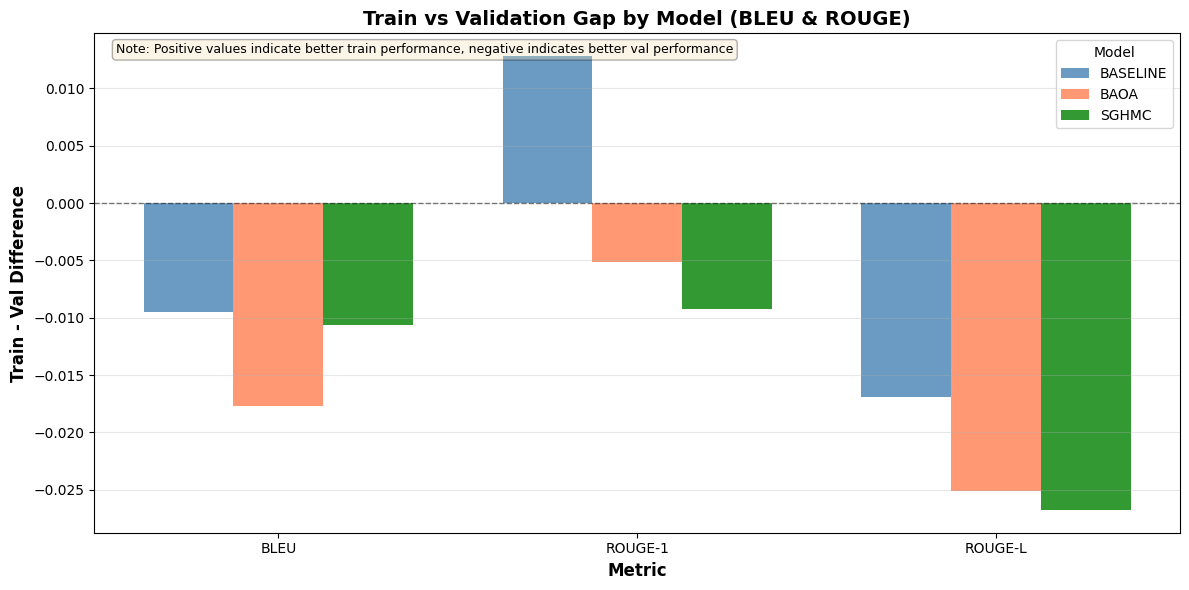

Train - Val difference barplot created successfully


In [81]:
# Create single plot showing train - val difference for both models (excluding Perplexity)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

models = list(model_stats.keys())
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L']  # Removed Perplexity and ROUGE-2
colors = ['steelblue', 'coral', 'green', 'orange', 'purple', 'brown']
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Calculate train - val differences for each model
model_differences = {}
for model in models:
    differences = []
    
    for metric in metrics:
        train_val = None
        val_val = None
        
        # Get train value
        if model_stats[model]['train']:
            stats = model_stats[model]['train']
            if metric == 'BLEU':
                train_val = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                train_val = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                train_val = stats['rougeL_mean']
        
        # Get val value
        if model_stats[model]['val']:
            stats = model_stats[model]['val']
            if metric == 'BLEU':
                val_val = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                val_val = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                val_val = stats['rougeL_mean']
        
        # Calculate difference (train - val)
        if train_val is not None and val_val is not None:
            differences.append(train_val - val_val)
        else:
            differences.append(0)
    
    model_differences[model] = differences

# Set up positions for grouped bars
x = np.arange(len(metrics))
width = 0.25

# Plot bars for each model
for i, model in enumerate(models):
    offset = width * (i - len(models)/2 + 0.5)
    ax.bar(x + offset, model_differences[model], width, 
           label=model.upper(), color=model_colors[model], alpha=0.8)

ax.set_xlabel('Metric', fontweight='bold', fontsize=12)
ax.set_ylabel('Train - Val Difference', fontweight='bold', fontsize=12)
ax.set_title('Train vs Validation Gap by Model (BLEU & ROUGE)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Model')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# Add note
ax.text(0.02, 0.98, 'Note: Positive values indicate better train performance, negative indicates better val performance', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "model_comparison_train_val_difference.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'model_comparison_train_val_difference.png'}")

plt.show()

print("Train - Val difference barplot created successfully")

Saved plot to evaluation_results\perplexity_train_val_difference.png


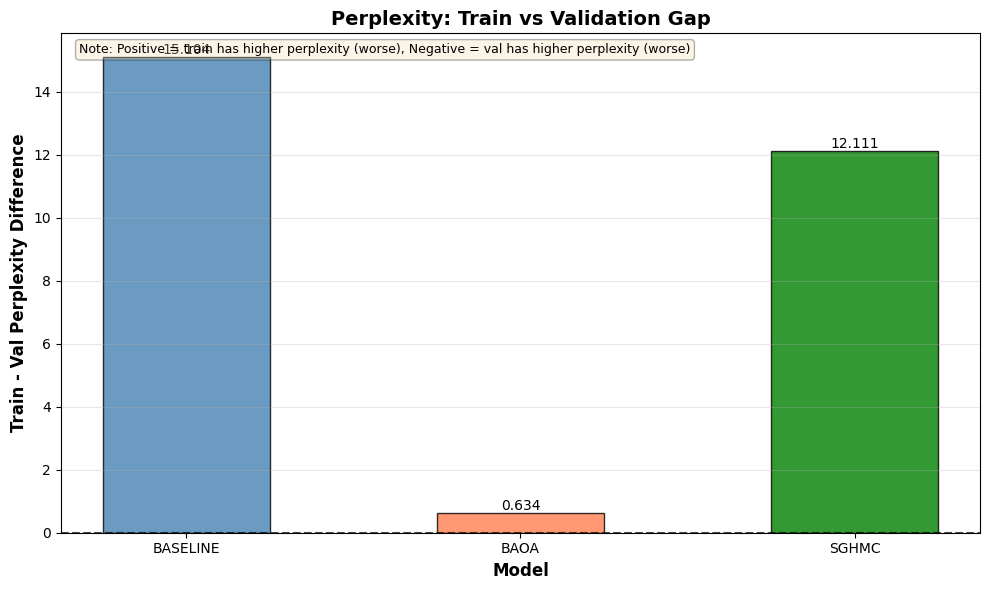

Perplexity train-val difference plot created successfully


In [82]:
# Create separate plot for Perplexity train-val difference
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract perplexity differences
perplexity_differences = {}
for model in models:
    train_perplexity = None
    val_perplexity = None
    
    if model_stats[model]['train']:
        train_perplexity = model_stats[model]['train']['perplexity_mean']
    
    if model_stats[model]['val']:
        val_perplexity = model_stats[model]['val']['perplexity_mean']
    
    if train_perplexity is not None and val_perplexity is not None:
        perplexity_differences[model] = train_perplexity - val_perplexity

# Set up positions
x = np.arange(len(models))
width = 0.5

# Plot bars
colors_list = [model_colors[model] for model in models]
bars = ax.bar(x, [perplexity_differences[model] for model in models], 
              width, color=colors_list, alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Train - Val Perplexity Difference', fontweight='bold', fontsize=12)
ax.set_title('Perplexity: Train vs Validation Gap', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models])
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model, bar) in enumerate(zip(models, bars)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Add note
ax.text(0.02, 0.98, 'Note: Positive = train has higher perplexity (worse), Negative = val has higher perplexity (worse)', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "perplexity_train_val_difference.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'perplexity_train_val_difference.png'}")

plt.show()

print("Perplexity train-val difference plot created successfully")

Saved plot to evaluation_results\metrics_vs_temperature.png


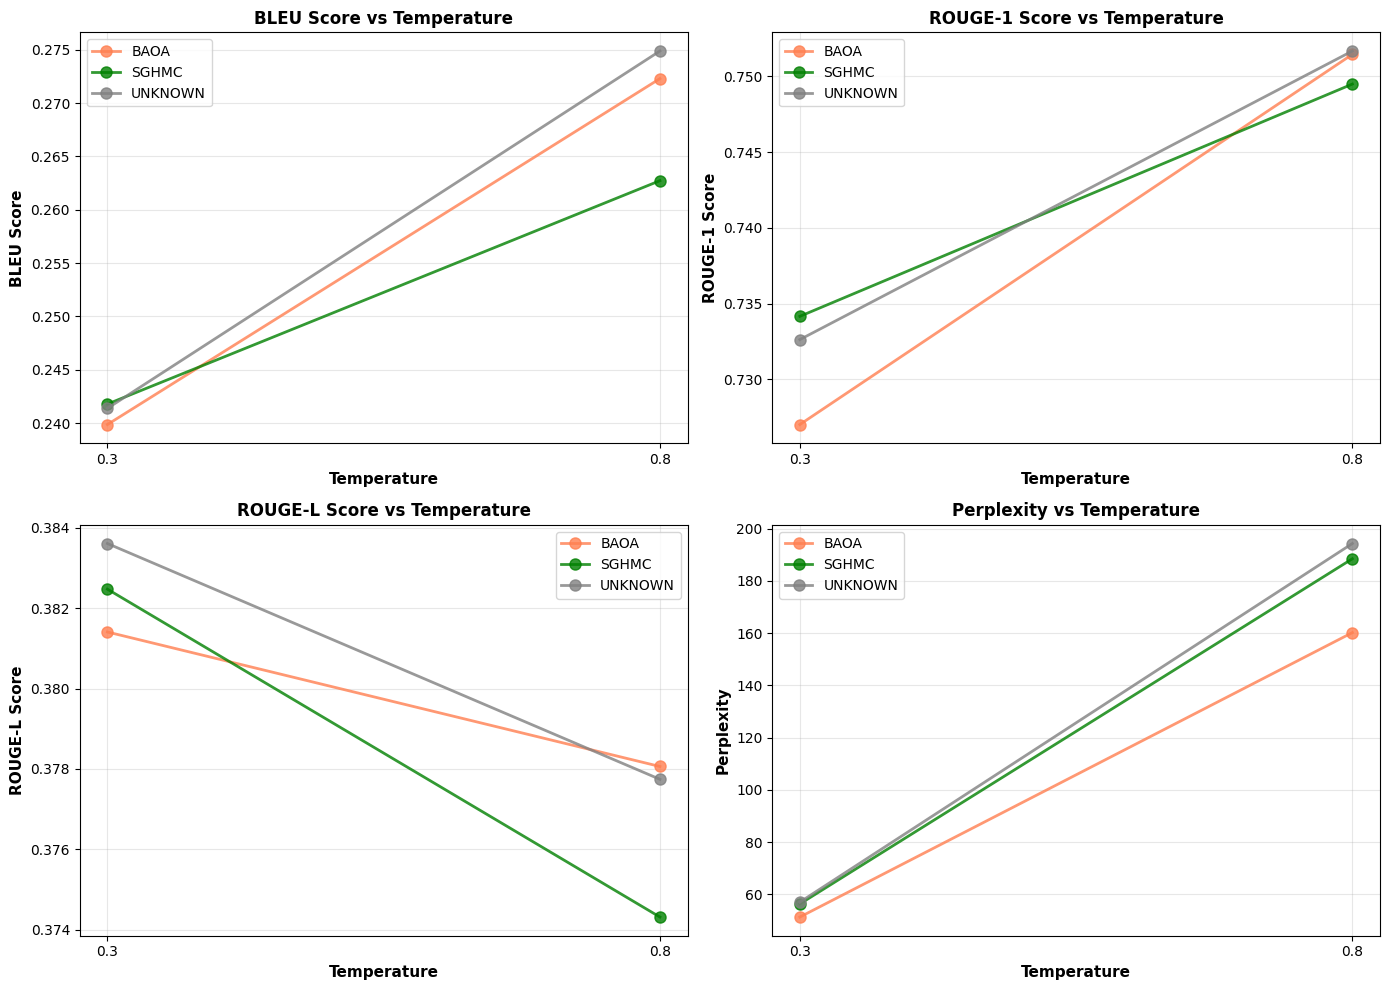

Metrics vs temperature plot created successfully


In [83]:
# Create plot showing metrics vs temperature for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect data grouped by model and temperature
temp_data = {}
for config_key, config_data in results_summary.items():
    model_name = config_data['model_name']
    temperature = config_data['temperature']
    
    if model_name not in temp_data:
        temp_data[model_name] = {}
    
    if temperature not in temp_data[model_name]:
        temp_data[model_name][temperature] = {
            'bleu': [],
            'rouge1': [],
            'rougeL': [],
            'perplexity': []
        }
    
    if config_data.get('overall'):
        temp_data[model_name][temperature]['bleu'].append(config_data['overall']['bleu'])
        temp_data[model_name][temperature]['rouge1'].append(config_data['overall']['rouge1'])
        temp_data[model_name][temperature]['rougeL'].append(config_data['overall']['rougeL'])
        temp_data[model_name][temperature]['perplexity'].append(config_data['overall']['perplexity'])

# Calculate averages for each temperature
temp_averages = {}
for model_name, temps in temp_data.items():
    temp_averages[model_name] = {}
    for temp, metrics in temps.items():
        temp_averages[model_name][temp] = {
            'bleu': np.mean(metrics['bleu']),
            'rouge1': np.mean(metrics['rouge1']),
            'rougeL': np.mean(metrics['rougeL']),
            'perplexity': np.mean(metrics['perplexity'])
        }

# Plot each metric
metrics_to_plot = [
    ('bleu', 'BLEU Score', axes[0, 0]),
    ('rouge1', 'ROUGE-1 Score', axes[0, 1]),
    ('rougeL', 'ROUGE-L Score', axes[1, 0]),
    ('perplexity', 'Perplexity', axes[1, 1])
]

colors_map = {'baseline': 'steelblue', 'baoa': 'coral', 'sghmc': 'green'}

for metric_key, metric_label, ax in metrics_to_plot:
    for model_name in sorted(temp_averages.keys()):
        temps = sorted(temp_averages[model_name].keys())
        values = [temp_averages[model_name][t][metric_key] for t in temps]
        
        color = colors_map.get(model_name, 'gray')
        ax.plot(temps, values, marker='o', linewidth=2, markersize=8, 
                label=model_name.upper(), color=color, alpha=0.8)
    
    ax.set_xlabel('Temperature', fontweight='bold', fontsize=11)
    ax.set_ylabel(metric_label, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric_label} vs Temperature', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show only actual temperature values
    if temps:
        ax.set_xticks(temps)

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "metrics_vs_temperature.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'metrics_vs_temperature.png'}")

plt.show()

print("Metrics vs temperature plot created successfully")

Saved plot to evaluation_results\metrics_vs_topk.png


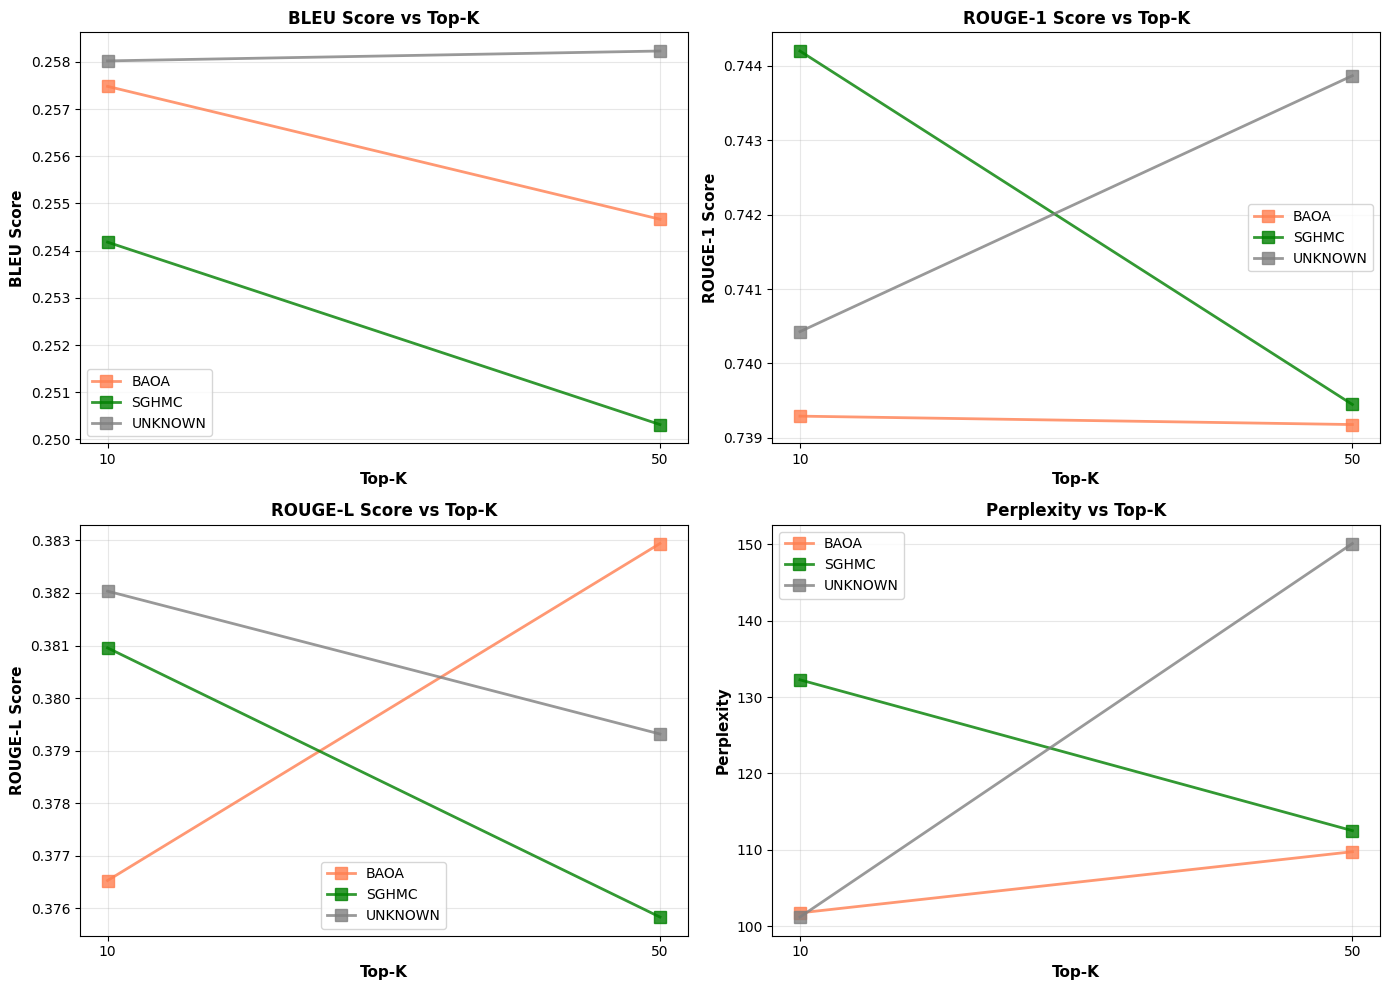

Metrics vs top-k plot created successfully


In [84]:
# Create plot showing metrics vs top_k for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect data grouped by model and top_k
topk_data = {}
for config_key, config_data in results_summary.items():
    model_name = config_data['model_name']
    top_k = config_data['top_k']
    
    if model_name not in topk_data:
        topk_data[model_name] = {}
    
    if top_k not in topk_data[model_name]:
        topk_data[model_name][top_k] = {
            'bleu': [],
            'rouge1': [],
            'rougeL': [],
            'perplexity': []
        }
    
    if config_data.get('overall'):
        topk_data[model_name][top_k]['bleu'].append(config_data['overall']['bleu'])
        topk_data[model_name][top_k]['rouge1'].append(config_data['overall']['rouge1'])
        topk_data[model_name][top_k]['rougeL'].append(config_data['overall']['rougeL'])
        topk_data[model_name][top_k]['perplexity'].append(config_data['overall']['perplexity'])

# Calculate averages for each top_k
topk_averages = {}
for model_name, topks in topk_data.items():
    topk_averages[model_name] = {}
    for topk, metrics in topks.items():
        topk_averages[model_name][topk] = {
            'bleu': np.mean(metrics['bleu']),
            'rouge1': np.mean(metrics['rouge1']),
            'rougeL': np.mean(metrics['rougeL']),
            'perplexity': np.mean(metrics['perplexity'])
        }

# Plot each metric
metrics_to_plot = [
    ('bleu', 'BLEU Score', axes[0, 0]),
    ('rouge1', 'ROUGE-1 Score', axes[0, 1]),
    ('rougeL', 'ROUGE-L Score', axes[1, 0]),
    ('perplexity', 'Perplexity', axes[1, 1])
]

colors_map = {'baseline': 'steelblue', 'baoa': 'coral', 'sghmc': 'green'}

for metric_key, metric_label, ax in metrics_to_plot:
    for model_name in sorted(topk_averages.keys()):
        topks = sorted(topk_averages[model_name].keys())
        values = [topk_averages[model_name][k][metric_key] for k in topks]
        
        color = colors_map.get(model_name, 'gray')
        ax.plot(topks, values, marker='s', linewidth=2, markersize=8, 
                label=model_name.upper(), color=color, alpha=0.8)
    
    ax.set_xlabel('Top-K', fontweight='bold', fontsize=11)
    ax.set_ylabel(metric_label, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric_label} vs Top-K', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show only actual top_k values
    if topks:
        ax.set_xticks(topks)

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "metrics_vs_topk.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'metrics_vs_topk.png'}")

plt.show()

print("Metrics vs top-k plot created successfully")

Saved plot to evaluation_results\metrics_vs_num_samples.png


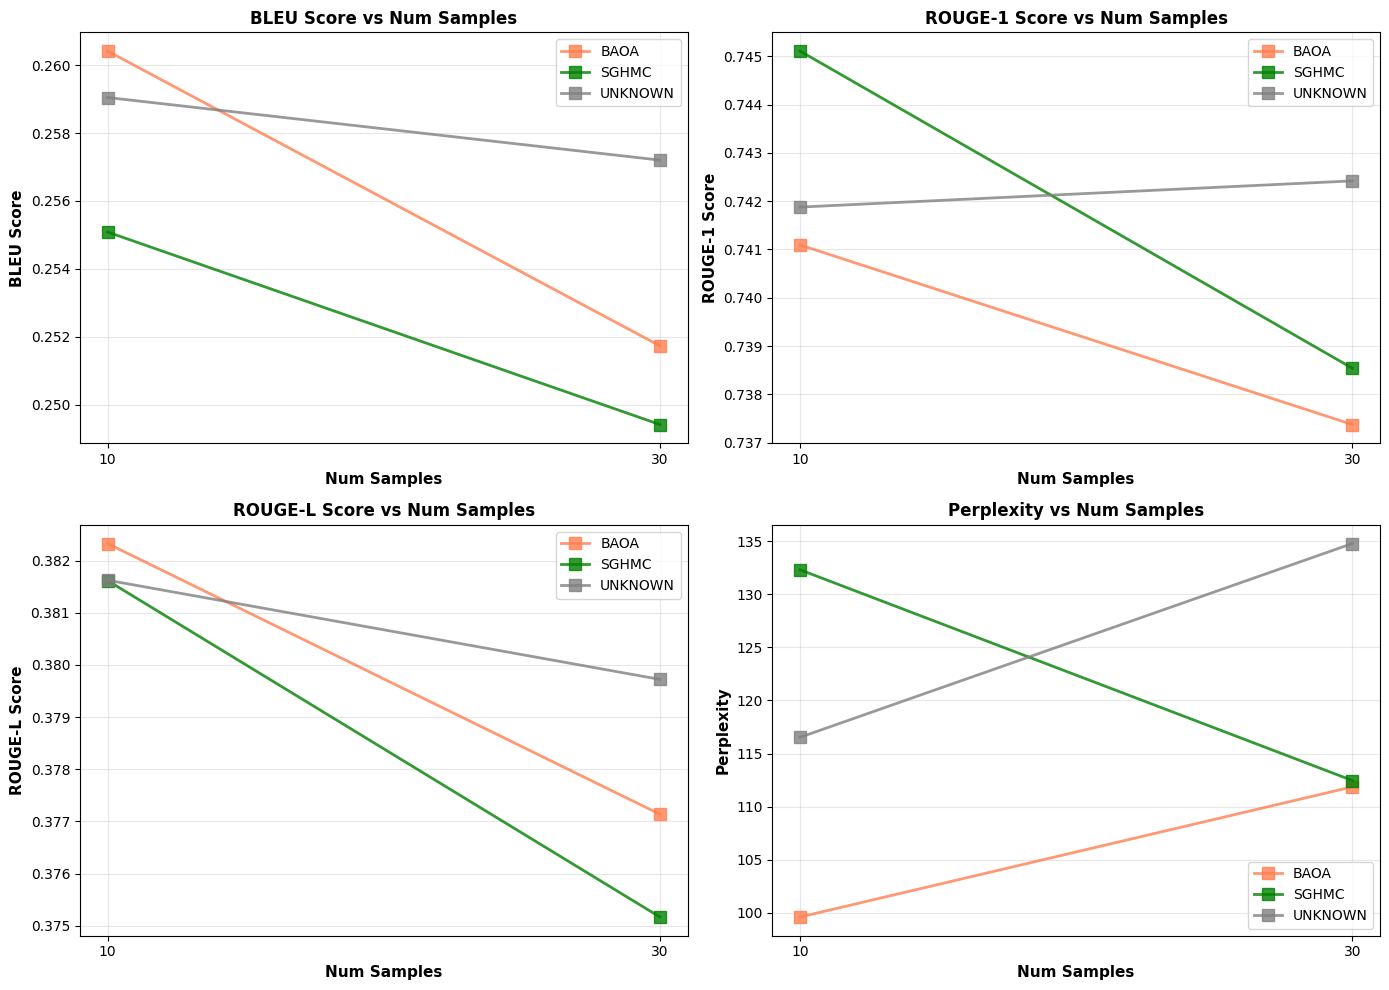

Metrics vs top-k plot created successfully


In [85]:
# Create plot showing metrics vs num_samples for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect data grouped by model and num_samples
topk_data = {}
for config_key, config_data in results_summary.items():
    model_name = config_data['model_name']
    num_samples = config_data['num_samples']
    
    if model_name not in topk_data:
        topk_data[model_name] = {}
    
    if num_samples not in topk_data[model_name]:
        topk_data[model_name][num_samples] = {
            'bleu': [],
            'rouge1': [],
            'rougeL': [],
            'perplexity': []
        }
    
    if config_data.get('overall'):
        topk_data[model_name][num_samples]['bleu'].append(config_data['overall']['bleu'])
        topk_data[model_name][num_samples]['rouge1'].append(config_data['overall']['rouge1'])
        topk_data[model_name][num_samples]['rougeL'].append(config_data['overall']['rougeL'])
        topk_data[model_name][num_samples]['perplexity'].append(config_data['overall']['perplexity'])

# Calculate averages for each num_samples
topk_averages = {}
for model_name, topks in topk_data.items():
    topk_averages[model_name] = {}
    for topk, metrics in topks.items():
        topk_averages[model_name][topk] = {
            'bleu': np.mean(metrics['bleu']),
            'rouge1': np.mean(metrics['rouge1']),
            'rougeL': np.mean(metrics['rougeL']),
            'perplexity': np.mean(metrics['perplexity'])
        }

# Plot each metric
metrics_to_plot = [
    ('bleu', 'BLEU Score', axes[0, 0]),
    ('rouge1', 'ROUGE-1 Score', axes[0, 1]),
    ('rougeL', 'ROUGE-L Score', axes[1, 0]),
    ('perplexity', 'Perplexity', axes[1, 1])
]

colors_map = {'baseline': 'steelblue', 'baoa': 'coral', 'sghmc': 'green'}

for metric_key, metric_label, ax in metrics_to_plot:
    for model_name in sorted(topk_averages.keys()):
        topks = sorted(topk_averages[model_name].keys())
        values = [topk_averages[model_name][k][metric_key] for k in topks]
        
        color = colors_map.get(model_name, 'gray')
        ax.plot(topks, values, marker='s', linewidth=2, markersize=8, 
                label=model_name.upper(), color=color, alpha=0.8)
    
    ax.set_xlabel('Num Samples', fontweight='bold', fontsize=11)
    ax.set_ylabel(metric_label, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric_label} vs Num Samples', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show only actual top_k values
    if topks:
        ax.set_xticks(topks)

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "metrics_vs_num_samples.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'metrics_vs_num_samples.png'}")

plt.show()

print("Metrics vs top-k plot created successfully")

In [86]:
# save to csv files
output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)
overall_csv_path = output_dir / "overall_results.csv"
train_csv_path = output_dir / "train_results.csv"
val_csv_path = output_dir / "val_results.csv"

## Visualize Results

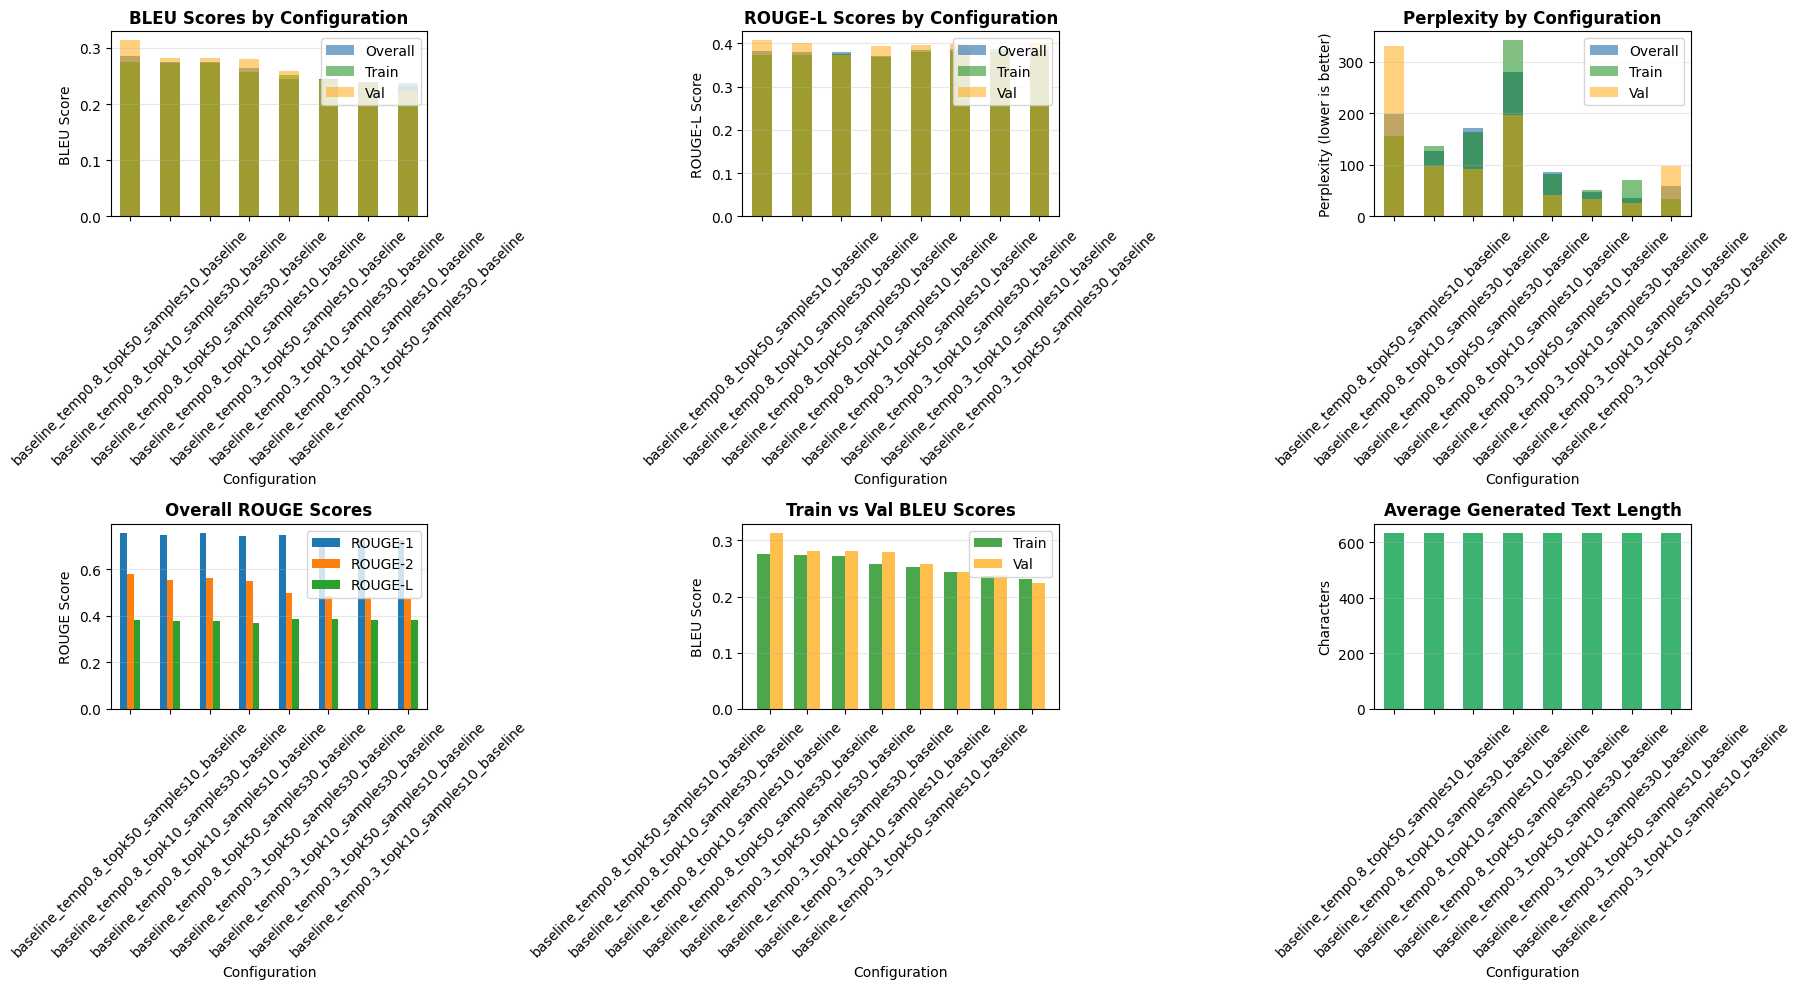

Visualizations complete


In [87]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: BLEU scores comparison (Overall, Train, Val)
ax1 = axes[0, 0]
if not df_overall.empty:
    df_overall['bleu'].plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['bleu'].plot(kind='bar', ax=ax1, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['bleu'].plot(kind='bar', ax=ax1, color='orange', alpha=0.5, label='Val')
ax1.set_title('BLEU Scores by Configuration', fontsize=12, fontweight='bold')
ax1.set_ylabel('BLEU Score')
ax1.set_xlabel('Configuration')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: ROUGE-L comparison
ax2 = axes[0, 1]
if not df_overall.empty:
    df_overall['rougeL'].plot(kind='bar', ax=ax2, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['rougeL'].plot(kind='bar', ax=ax2, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['rougeL'].plot(kind='bar', ax=ax2, color='orange', alpha=0.5, label='Val')
ax2.set_title('ROUGE-L Scores by Configuration', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROUGE-L Score')
ax2.set_xlabel('Configuration')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Perplexity comparison
ax3 = axes[0, 2]
if not df_overall.empty:
    df_overall['perplexity'].plot(kind='bar', ax=ax3, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['perplexity'].plot(kind='bar', ax=ax3, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['perplexity'].plot(kind='bar', ax=ax3, color='orange', alpha=0.5, label='Val')
ax3.set_title('Perplexity by Configuration', fontsize=12, fontweight='bold')
ax3.set_ylabel('Perplexity (lower is better)')
ax3.set_xlabel('Configuration')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Overall ROUGE scores (1, 2, L)
ax4 = axes[1, 0]
if not df_overall.empty:
    df_overall[['rouge1', 'rouge2', 'rougeL']].plot(kind='bar', ax=ax4)
    ax4.set_title('Overall ROUGE Scores', fontsize=12, fontweight='bold')
    ax4.set_ylabel('ROUGE Score')
    ax4.set_xlabel('Configuration')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    ax4.grid(axis='y', alpha=0.3)

# Plot 5: Train vs Val BLEU comparison side-by-side
ax5 = axes[1, 1]
if not df_train.empty and not df_val.empty:
    x = np.arange(len(df_train))
    width = 0.35
    ax5.bar(x - width/2, df_train['bleu'], width, label='Train', color='green', alpha=0.7)
    ax5.bar(x + width/2, df_val['bleu'], width, label='Val', color='orange', alpha=0.7)
    ax5.set_title('Train vs Val BLEU Scores', fontsize=12, fontweight='bold')
    ax5.set_ylabel('BLEU Score')
    ax5.set_xlabel('Configuration')
    ax5.set_xticks(x)
    ax5.set_xticklabels(df_train.index, rotation=45, ha='right')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)

# Plot 6: Average text length
ax6 = axes[1, 2]
if not df_overall.empty:
    df_overall['avg_text_length'].plot(kind='bar', ax=ax6, color='mediumseagreen')
    ax6.set_title('Average Generated Text Length', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Characters')
    ax6.set_xlabel('Configuration')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations complete")


## Save Results to JSON

In [55]:
from datetime import datetime
from pathlib import Path
import json

# Save results to JSON file (append by adding keys, preserve existing dictionaries)
output_path = Path("llm_results/evaluation_metrics_results.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

# Merge results_summary (baseline) and samplers_results into one dict for saving
combined_results = {}

# Add baseline results
if 'results_summary' in globals() and results_summary:
    combined_results.update(results_summary)
    print(f"Added {len(results_summary)} baseline configurations")

# Add sampler results
if 'samplers_results' in globals() and samplers_results:
    combined_results.update(samplers_results)
    print(f"Added {len(samplers_results)} sampler configurations")

print(f"Total combined: {len(combined_results)} configurations")

# Convert combined results to serializable format
serializable_results = {}
for config_key, config_data in combined_results.items():
    serializable_results[config_key] = {
        'model_path': str(config_data['model_path']),
        'model_name': str(config_data.get('model_name', 'unknown')),
        'temperature': float(config_data['temperature']) if config_data['temperature'] != 'unknown' else 'unknown',
        'top_k': int(config_data['top_k']) if config_data['top_k'] != 'unknown' else 'unknown',
        'overall': config_data.get('overall'),
        'train': config_data.get('train'),
        'val': config_data.get('val')
    }

# Load existing data if present
existing_data = {}
if output_path.exists():
    try:
        with open(output_path, 'r', encoding='utf-8') as f:
            existing_data = json.load(f) or {}
    except Exception as e:
        print(f"Warning: could not read existing JSON; proceeding with new file. Error: {e}")

# Start from existing metrics dict (or empty)
existing_metrics = {}
if isinstance(existing_data.get('metrics'), dict):
    existing_metrics = existing_data['metrics'].copy()

# Helper: deep-add merge (only add missing keys; never overwrite)
def merge_add_missing(target, source):
    if not isinstance(source, dict) or not isinstance(target, dict):
        return target
    for k, v in source.items():
        if k not in target:
            target[k] = v
        else:
            if isinstance(target[k], dict) and isinstance(v, dict):
                merge_add_missing(target[k], v)
            # else: keep existing value, do not overwrite
    return target

# Append/merge by adding new keys only
new_keys = 0
updated_existing = 0
for k, v in serializable_results.items():
    if k in existing_metrics:
        before = json.dumps(existing_metrics[k], sort_keys=True)
        existing_metrics[k] = merge_add_missing(existing_metrics[k], v)
        after = json.dumps(existing_metrics[k], sort_keys=True)
        if before != after:
            updated_existing += 1
    else:
        existing_metrics[k] = v
        new_keys += 1

# Helper to recompute totals from merged metrics
def _sum_total(metrics_dict, subset):
    s = 0
    for entry in metrics_dict.values():
        subset_metrics = entry.get(subset)
        if subset_metrics and isinstance(subset_metrics.get('num_samples'), (int, float)):
            s += int(subset_metrics['num_samples'])
    return s

# Build merged output (preserve other existing fields)
output_data = existing_data if isinstance(existing_data, dict) else {}
output_data['metrics'] = existing_metrics
output_data['num_configurations'] = len(existing_metrics)
output_data['total_samples'] = {
    'overall': _sum_total(existing_metrics, 'overall'),
    'train': _sum_total(existing_metrics, 'train'),
    'val': _sum_total(existing_metrics, 'val')
}
# Keep prior evaluation_timestamp if present; add last_update for traceability
output_data['last_update'] = datetime.now().isoformat()

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=2, default=str)

print(f"\n✓ Appended {new_keys} new configuration(s); updated {updated_existing} existing with missing keys.")
print(f"  Total configurations in file: {len(existing_metrics)}")
print(f"  Saved to: {output_path}")


Added 8 baseline configurations
Added 16 sampler configurations
Total combined: 24 configurations

✓ Appended 16 new configuration(s); updated 0 existing with missing keys.
  Total configurations in file: 24
  Saved to: llm_results\evaluation_metrics_results.json


## Summary Statistics

In [123]:
print("="*100)
print("SUMMARY STATISTICS")
print("="*100)

# Overall Statistics
if not df_overall.empty:
    print("\n### OVERALL METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_config = df_overall['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_config}")
    print(f"  BLEU: {df_overall.loc[best_bleu_config, 'bleu']:.4f}")
    print(f"  ROUGE-1: {df_overall.loc[best_bleu_config, 'rouge1']:.4f}")
    print(f"  ROUGE-L: {df_overall.loc[best_bleu_config, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_overall.loc[best_bleu_config, 'perplexity']:.2f}")

    print(f"\nBest ROUGE-L Score:")
    best_rouge_config = df_overall['rougeL'].idxmax()
    print(f"  Configuration: {best_rouge_config}")
    print(f"  ROUGE-L: {df_overall.loc[best_rouge_config, 'rougeL']:.4f}")
    print(f"  BLEU: {df_overall.loc[best_rouge_config, 'bleu']:.4f}")
    print(f"  Perplexity: {df_overall.loc[best_rouge_config, 'perplexity']:.2f}")

    print(f"\nLowest Perplexity:")
    best_ppl_config = df_overall['perplexity'].idxmin()
    print(f"  Configuration: {best_ppl_config}")
    print(f"  Perplexity: {df_overall.loc[best_ppl_config, 'perplexity']:.2f}")
    print(f"  BLEU: {df_overall.loc[best_ppl_config, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_overall.loc[best_ppl_config, 'rougeL']:.4f}")

    print(f"\nOverall Statistics:")
    print(f"  Mean BLEU: {df_overall['bleu'].mean():.4f} ± {df_overall['bleu'].std():.4f}")
    print(f"  Mean ROUGE-1: {df_overall['rouge1'].mean():.4f} ± {df_overall['rouge1'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_overall['rougeL'].mean():.4f} ± {df_overall['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_overall['perplexity'].mean():.2f} ± {df_overall['perplexity'].std():.2f}")

# Train Statistics
if not df_train.empty:
    print("\n" + "="*100)
    print("### TRAIN PROMPTS METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_train = df_train['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_train}")
    print(f"  BLEU: {df_train.loc[best_bleu_train, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_train.loc[best_bleu_train, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_train.loc[best_bleu_train, 'perplexity']:.2f}")

    print(f"\nTrain Statistics:")
    print(f"  Mean BLEU: {df_train['bleu'].mean():.4f} ± {df_train['bleu'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_train['rougeL'].mean():.4f} ± {df_train['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_train['perplexity'].mean():.2f} ± {df_train['perplexity'].std():.2f}")

# Val Statistics
if not df_val.empty:
    print("\n" + "="*100)
    print("### VALIDATION PROMPTS METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_val = df_val['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_val}")
    print(f"  BLEU: {df_val.loc[best_bleu_val, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_val.loc[best_bleu_val, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_val.loc[best_bleu_val, 'perplexity']:.2f}")

    print(f"\nValidation Statistics:")
    print(f"  Mean BLEU: {df_val['bleu'].mean():.4f} ± {df_val['bleu'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_val['rougeL'].mean():.4f} ± {df_val['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_val['perplexity'].mean():.2f} ± {df_val['perplexity'].std():.2f}")

# Comparison
if not df_train.empty and not df_val.empty:
    print("\n" + "="*100)
    print("### TRAIN vs VAL COMPARISON ###")
    print(f"\nBLEU Score Difference (Train - Val):")
    for config in df_train.index:
        if config in df_val.index:
            diff = df_train.loc[config, 'bleu'] - df_val.loc[config, 'bleu']
            print(f"  {config}: {diff:+.4f}")
    
    print(f"\nPerplexity Difference (Train - Val):")
    for config in df_train.index:
        if config in df_val.index:
            diff = df_train.loc[config, 'perplexity'] - df_val.loc[config, 'perplexity']
            print(f"  {config}: {diff:+.2f}")

print("\n" + "="*100)


SUMMARY STATISTICS

### OVERALL METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_samples1_run_20251119-120219
  BLEU: 0.0610
  ROUGE-1: 0.2441
  ROUGE-L: 0.1854
  Perplexity: 104.40

Best ROUGE-L Score:
  Configuration: baoa_temp0.3_topk10_samples1_run_20251118-124935
  ROUGE-L: 0.1910
  BLEU: 0.0555
  Perplexity: 55.51

Lowest Perplexity:
  Configuration: baoa_temp0.3_topk10_samples1_run_20251118-124935
  Perplexity: 55.51
  BLEU: 0.0555
  ROUGE-L: 0.1910

Overall Statistics:
  Mean BLEU: 0.0583 ± 0.0039
  Mean ROUGE-1: 0.2489 ± 0.0068
  Mean ROUGE-L: 0.1882 ± 0.0040
  Mean Perplexity: 79.96 ± 34.57

### TRAIN PROMPTS METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_samples1_run_20251119-120219
  BLEU: 0.0630
  ROUGE-L: 0.2087
  Perplexity: 46.23

Train Statistics:
  Mean BLEU: 0.0610 ± 0.0028
  Mean ROUGE-L: 0.2019 ± 0.0096
  Mean Perplexity: 51.27 ± 7.12

### VALIDATION PROMPTS METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_

# Sampler vs Baseline: Train/Val Comparison Across Hyperparameters
This section loads last_eval_samplers.json and last_eval_baseline.json, normalizes their records, and compares models across temperature, top_k, and num_samples. We summarize train and val splits separately and combined.

In [1]:
# Load and normalize evaluation JSONs for sampler/baseline comparison
import json, re, os
import pandas as pd
from pathlib import Path

samplers_path = Path(r"c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\adl-bnn-textgen\checkpoints\generation_results\last_eval_samplers.json")
baseline_path = Path(r"c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\adl-bnn-textgen\checkpoints\generation_results\last_eval_baseline.json")

def load_json(path: Path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

samplers = load_json(samplers_path)
baseline = load_json(baseline_path)

def infer_sampler(model_type: str, model_path: str):
    if model_type == 'standard':
        return 'baseline'
    # Try to extract sampler name like 'baoa_sampler', 'sghmc_sampler', 'vi'
    m = re.search(r"samplers/(.*?)(?:/|\\)", model_path.replace("\\", "/"))
    if m:
        name = m.group(1)
        # normalize common names
        name = name.replace('_sampler','')
        return name
    # fallback: try known tokens in path
    for token in ['baoa','sghmc','vi','ekf']:
        if token in model_path.lower():
            return token
    return 'bayesian'

def records_to_rows(d: dict):
    rows = []
    for rid, rec in d.items():
        mt = rec.get('model_type')
        mp = rec.get('model_path','')
        sampler = infer_sampler(mt, mp)
        src = rec.get('prompt_source','unknown')
        temperature = rec.get('temperature')
        top_k = rec.get('top_k')
        num_samples = rec.get('num_samples')
        txt = rec.get('generated_text','')
        txt_len_words = len(txt.split()) if isinstance(txt, str) else None
        ui = rec.get('uncertainty_info') or {}
        avg_unc = ui.get('avg_uncertainty')
        max_unc = ui.get('max_uncertainty')
        rows.append({
            'id': rid,
            'sampler': sampler,
            'model_type': mt,
            'source': src,
            'temperature': temperature,
            'top_k': top_k,
            'num_samples': num_samples,
            'avg_uncertainty': avg_unc,
            'max_uncertainty': max_unc,
            'text_len_words': txt_len_words,
        })
    return rows

sampler_rows = records_to_rows(samplers)
baseline_rows = records_to_rows(baseline)
df = pd.DataFrame(sampler_rows + baseline_rows)

# Identify present sampler groups
present_samplers = sorted(df['sampler'].dropna().unique().tolist())
print('Present samplers:', present_samplers)

# Helper aggregations
def agg_summary(group_cols):
    return (
        df.groupby(group_cols)
          .agg(avg_uncertainty_mean=('avg_uncertainty','mean'),
               avg_uncertainty_std=('avg_uncertainty','std'),
               max_uncertainty_mean=('max_uncertainty','mean'),
               text_len_words_mean=('text_len_words','mean'),
               count=('id','count'))
          .reset_index()
    )

# Train/Val separate summaries
per_split = agg_summary(['sampler','source'])
print('\nPer-split summary (sampler x source):')
display(per_split.sort_values(['sampler','source']))

# Combined (train+val) summary per sampler
combined = agg_summary(['sampler'])
print('\nCombined summary (sampler):')
display(combined.sort_values(['sampler']))

# Hyperparameter breakdown per split
per_split_hparams = agg_summary(['sampler','source','temperature','top_k','num_samples'])
print('\nPer-split hyperparameter breakdown:')
display(per_split_hparams.sort_values(['sampler','source','temperature','top_k','num_samples']))

# Compact combined hyperparameter breakdown
combined_hparams = agg_summary(['sampler','temperature','top_k','num_samples'])
print('\nCombined hyperparameter breakdown:')
display(combined_hparams.sort_values(['sampler','temperature','top_k','num_samples']))

# Quick comparative view: focus on three primary models if available
primary = [m for m in ['baseline','baoa','sghmc','vi'] if m in present_samplers][:3]
print('\nPrimary models chosen:', primary)
primary_split = per_split[per_split['sampler'].isin(primary)].sort_values(['sampler','source'])
display(primary_split)

# Note: baseline lacks uncertainty metrics; text length is used as proxy here.

Present samplers: ['baoa', 'baseline', 'sghmc']

Per-split summary (sampler x source):


,sampler,source,avg_uncertainty_mean,avg_uncertainty_std,max_uncertainty_mean,text_len_words_mean,count
0,baoa,train,0.673258,0.290093,2.675842,125.125000,24
1,baoa,val,0.697640,0.299781,2.678018,129.187500,16
2,baseline,train,NaN,NaN,NaN,126.625000,24
3,baseline,val,NaN,NaN,NaN,127.875000,16
4,sghmc,train,0.683786,0.261516,2.639063,128.833333,24
5,sghmc,val,0.697902,0.305001,2.647002,129.312500,16



Combined summary (sampler):


,sampler,avg_uncertainty_mean,avg_uncertainty_std,max_uncertainty_mean,text_len_words_mean,count
0,baoa,0.683011,0.290414,2.676712,126.750,40
1,baseline,NaN,NaN,NaN,127.125,40
2,sghmc,0.689433,0.275973,2.642239,129.025,40



Per-split hyperparameter breakdown:


,sampler,source,temperature,top_k,num_samples,avg_uncertainty_mean,avg_uncertainty_std,max_uncertainty_mean,text_len_words_mean,count
0,baoa,train,0.3,10,10,0.364746,0.041668,2.305582,122.333333,3
1,baoa,train,0.3,10,30,0.381752,0.028987,2.351818,127.666667,3
2,baoa,train,0.3,50,10,0.436728,0.052864,2.352851,131.666667,3
3,baoa,train,0.3,50,30,0.398528,0.098274,2.237618,126.666667,3
4,baoa,train,0.8,10,10,0.965049,0.056182,3.026313,125.000000,3
5,baoa,train,0.8,10,30,0.971576,0.010746,2.944503,122.666667,3
6,baoa,train,0.8,50,10,0.890147,0.060979,3.132135,119.333333,3
7,baoa,train,0.8,50,30,0.977542,0.087945,3.055913,125.666667,3
8,baoa,val,0.3,10,10,0.363281,0.049712,2.357544,127.500000,2
9,baoa,val,0.3,10,30,0.416429,0.011294,2.278242,134.000000,2



Combined hyperparameter breakdown:


,sampler,temperature,top_k,num_samples,avg_uncertainty_mean,avg_uncertainty_std,max_uncertainty_mean,text_len_words_mean,count
0,baoa,0.3,10,10,0.364160,0.038556,2.326367,124.4,5
1,baoa,0.3,10,30,0.395623,0.028509,2.322388,130.2,5
2,baoa,0.3,50,10,0.441295,0.039436,2.351420,133.8,5
3,baoa,0.3,50,30,0.405368,0.070618,2.250858,129.8,5
4,baoa,0.8,10,10,0.961237,0.063279,3.024840,126.0,5
5,baoa,0.8,10,30,0.981263,0.021279,2.967473,124.4,5
6,baoa,0.8,50,10,0.948132,0.091680,3.095721,121.2,5
7,baoa,0.8,50,30,0.967010,0.065314,3.074633,124.2,5
8,baseline,0.3,10,10,NaN,NaN,NaN,129.2,5
9,baseline,0.3,10,30,NaN,NaN,NaN,131.2,5



Primary models chosen: ['baseline', 'baoa', 'sghmc']


,sampler,source,avg_uncertainty_mean,avg_uncertainty_std,max_uncertainty_mean,text_len_words_mean,count
0,baoa,train,0.673258,0.290093,2.675842,125.125000,24
1,baoa,val,0.697640,0.299781,2.678018,129.187500,16
2,baseline,train,NaN,NaN,NaN,126.625000,24
3,baseline,val,NaN,NaN,NaN,127.875000,16
4,sghmc,train,0.683786,0.261516,2.639063,128.833333,24
5,sghmc,val,0.697902,0.305001,2.647002,129.312500,16


In [44]:
# Append evaluation results by adding new keys only (no overwrite)
from datetime import datetime
from pathlib import Path
import json

output_path = Path("llm_results/evaluation_metrics_results.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

# Prepare current run results
serializable_results = {}
for config_key, config_data in results_summary.items():
    serializable_results[config_key] = {
        'model_path': str(config_data['model_path']),
        'temperature': float(config_data['temperature']) if config_data['temperature'] != 'unknown' else 'unknown',
        'top_k': int(config_data['top_k']) if config_data['top_k'] != 'unknown' else 'unknown',
        'overall': config_data['overall'],
        'train': config_data['train'],
        'val': config_data['val']
    }

# Load existing JSON if present
existing_data = {}
if output_path.exists():
    try:
        with open(output_path, 'r', encoding='utf-8') as f:
            existing_data = json.load(f) or {}
    except Exception as e:
        print(f"Warning: could not read existing file; starting fresh. Error: {e}")

# Merge by adding new keys only
existing_metrics = {}
if isinstance(existing_data.get('metrics'), dict):
    existing_metrics = existing_data['metrics'].copy()

new_keys = 0
skipped_keys = 0
for k, v in serializable_results.items():
    if k in existing_metrics:
        skipped_keys += 1
        continue
    existing_metrics[k] = v
    new_keys += 1

# Recompute totals from merged metrics
def _sum_total(metrics_dict, subset):
    s = 0
    for entry in metrics_dict.values():
        subset_metrics = entry.get(subset)
        if subset_metrics and isinstance(subset_metrics.get('num_samples'), (int, float)):
            s += int(subset_metrics['num_samples'])
    return s

output_data = dict(existing_data) if isinstance(existing_data, dict) else {}
output_data['metrics'] = existing_metrics
output_data['num_configurations'] = len(existing_metrics)
output_data['total_samples'] = {
    'overall': _sum_total(existing_metrics, 'overall'),
    'train': _sum_total(existing_metrics, 'train'),
    'val': _sum_total(existing_metrics, 'val')
}
output_data['last_update'] = datetime.now().isoformat()

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=2)

print(f"\u2713 Appended {new_keys} new configuration(s); skipped {skipped_keys} existing.")
print(f"  Saved to: {output_path}")


✓ Appended 8 new configuration(s); skipped 0 existing.
  Saved to: llm_results\evaluation_metrics_results.json
